# Exploratory notebook

In this notebook we load a root file in using `NanoEventsFactory.from_root` with the `NanoAODSchema`.

We define useful variables for further selections.

In [1]:
from collections import defaultdict
import pickle as pkl
import pyarrow as pa
import awkward as ak
import numpy as np
import pandas as pd
import json
import os
import shutil
import pathlib
from typing import List, Optional
import pyarrow.parquet as pq

import importlib.resources

from coffea import processor
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import candidate, vector
import matplotlib.pyplot as plt
import numpy as np
import json

/Users/cmantill/miniconda3/envs/hww/lib/python3.7/site-packages/numba/core/cpu.py:77: UserWarning: Numba extension module 'awkward1._connect._numba' failed to load due to 'ImportError(generic_type: type "kernel_lib" is already registered!)'.
  numba.core.entrypoints.init_all()


In [2]:
import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch ")
warnings.filterwarnings("ignore", category=DeprecationWarning)
np.seterr(invalid='ignore')

def dsum(*dicts):
    ret = defaultdict(int)
    for d in dicts:
        for k, v in d.items():
            ret[k] += v
    return dict(ret)


def pad_val(
    arr: ak.Array,
    value: float,
    target: int = None,
    axis: int = 0,
    to_numpy: bool = False,
    clip: bool = True,
):
    """
    pads awkward array up to ``target`` index along axis ``axis`` with value ``value``,
    optionally converts to numpy array
    """
    if target:
        ret = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=None)
    else:
        ret = ak.fill_none(arr, value, axis=None)
    return ret.to_numpy() if to_numpy else ret


def build_p4(cand):
    return ak.zip(
        {
            "pt": cand.pt,
            "eta": cand.eta,
            "phi": cand.phi,
            "mass": cand.mass,
            "charge": cand.charge,
        },
        with_name="PtEtaPhiMCandidate",
        behavior=candidate.behavior,
    )

## Load the file (check events 92, 48)

In [19]:
file = 'dy_sample.root'
NanoAODSchema.mixins["SubJet"] = "FatJet"
NanoAODSchema.mixins["PFCands"] = "PFCand"
events = NanoEventsFactory.from_root(file, schemaclass=NanoAODSchema, entry_stop=10000).events()
events.PFCands

<PFCandArray [[], [PFCand, ... PFCand, PFCand]] type='10000 * var * pFCand'>

In [5]:
with open(f"03_31_ak8.json") as f:
    tagger_vars = json.load(f)

# btag vars
for var in tagger_vars["pf_features"]["var_names"]:
    if "btag" in var:
        feature_dict[var] = jet_ak_pfcands[var[len("pfcand_"):]]

In [10]:
# basic definitions
good_muons = (
    (events.Muon.pt > 30)
    & (np.abs(events.Muon.eta) < 2.4)
    & (np.abs(events.Muon.dz) < 0.1)
    & (np.abs(events.Muon.dxy) < 0.05)
    & (events.Muon.sip3d <= 4.0)
    & events.Muon.mediumId
)
    
good_electrons = (
    (events.Electron.pt > 38)
    & (np.abs(events.Electron.eta) < 2.4)
    & ((np.abs(events.Electron.eta) < 1.44) | (np.abs(events.Electron.eta) > 1.57))
    & (np.abs(events.Electron.dz) < 0.1)
    & (np.abs(events.Electron.dxy) < 0.05)
    & (events.Electron.sip3d <= 4.0)
    & (events.Electron.mvaFall17V2noIso_WP90)
)
n_good_electrons = ak.sum(good_electrons, axis=1)

# get candidate lepton
goodleptons = ak.concatenate([events.Muon[good_muons], events.Electron[good_electrons]], axis=1)    # concat muons and electrons
goodleptons = goodleptons[ak.argsort(goodleptons.pt, ascending=False)]      # sort by pt
candidatelep = ak.firsts(goodleptons)   # pick highest pt

candidatelep_p4 = build_p4(candidatelep)    # build p4 for candidate lepton

In [11]:
fatjets = events.FatJet
good_fatjets = (
    (fatjets.pt > 200)
    & (abs(fatjets.eta) < 2.5)
    & fatjets.isTight
)

n_fatjets = ak.sum(good_fatjets, axis=1)

good_fatjets = fatjets[good_fatjets]        # select good fatjets
 
good_fatjets = good_fatjets[ak.argsort(good_fatjets.pt, ascending=False)]    # sort by pt

# lep_in_fj_overlap_bool = good_fatjets.delta_r(candidatelep_p4) > 0.1   # pick the ones within delta r
lep_in_fj_overlap_bool = ~ak.is_none(ak.firsts(good_fatjets.delta_r(candidatelep_p4) > 0.1))

# good_fatjets = good_fatjets[lep_in_fj_overlap_bool]
good_fatjets = ak.mask(good_fatjets, lep_in_fj_overlap_bool)

fj_idx_lep = ak.argmin(good_fatjets.delta_r(candidatelep_p4), axis=1, keepdims=True)
candidatefj_lep = ak.firsts(good_fatjets[fj_idx_lep])

candidatefj_lep

<FatJetArray [None, None, None, ... None, None, None] type='10000 * ?fatJet'>

In [22]:
from typing import Dict

import numpy as np
from scipy.special import softmax
import awkward as ak
from coffea.nanoevents.methods.base import NanoEventsArray
def get_pfcands_features(
    tagger_vars: dict,
    preselected_events: NanoEventsArray,
    fj_idx_lep,
    fatjet_label: str = "FatJetAK15",
    pfcands_label: str = "FatJetPFCands",
    normalize: bool = True,
) -> Dict[str, np.ndarray]:
    """
    Extracts the pf_candidate features specified in the ``tagger_vars`` dict from the
    ``preselected_events`` and returns them as a dict of numpy arrays
    """

    feature_dict = {}

    jet = ak.firsts(preselected_events[fatjet_label][fj_idx_lep])

    msk = preselected_events[pfcands_label].jetIdx == ak.firsts(fj_idx_lep)
    jet_ak_pfcands = preselected_events[pfcands_label][msk]
    jet_pfcands = (preselected_events.PFCands[jet_ak_pfcands.pFCandsIdx])

    # negative eta jets have -1 sign, positive eta jets have +1
    eta_sign = ak.values_astype(jet_pfcands.eta > 0, int) * 2 - 1
    feature_dict["pfcand_etarel"] = eta_sign * (jet_pfcands.eta - jet.eta)
    feature_dict["pfcand_phirel"] = jet.delta_phi(jet_pfcands)
    feature_dict["pfcand_abseta"] = np.abs(jet_pfcands.eta)

    feature_dict["pfcand_pt_log_nopuppi"] = np.log(jet_pfcands.pt)
    feature_dict["pfcand_e_log_nopuppi"] = np.log(jet_pfcands.energy)

    pdgIds = jet_pfcands.pdgId
    feature_dict["pfcand_isEl"] = np.abs(pdgIds) == 11
    feature_dict["pfcand_isMu"] = np.abs(pdgIds) == 13
    feature_dict["pfcand_isChargedHad"] = np.abs(pdgIds) == 211
    feature_dict["pfcand_isGamma"] = np.abs(pdgIds) == 22
    feature_dict["pfcand_isNeutralHad"] = np.abs(pdgIds) == 130

    feature_dict["pfcand_charge"] = jet_pfcands.charge
    feature_dict["pfcand_VTX_ass"] = jet_pfcands.pvAssocQuality
    feature_dict["pfcand_lostInnerHits"] = jet_pfcands.lostInnerHits
    feature_dict["pfcand_quality"] = jet_pfcands.trkQuality

    feature_dict["pfcand_normchi2"] = np.floor(jet_pfcands.trkChi2)

    feature_dict["pfcand_dz"] = jet_pfcands.dz
    feature_dict["pfcand_dxy"] = jet_pfcands.d0
    feature_dict["pfcand_dzsig"] = jet_pfcands.dz / jet_pfcands.dzErr
    feature_dict["pfcand_dxysig"] = jet_pfcands.d0 / jet_pfcands.d0Err

    print('finished building feature_dict')

    # btag vars
    for var in tagger_vars["pf_features"]["var_names"]:
        if "btag" in var:
            feature_dict[var] = jet_ak_pfcands[var[len("pfcand_"):]]

    feature_dict["pfcand_mask"] = (
        ~(
            ak.pad_none(
                # padding to have at least one pf candidate in the graph
                pad_val(feature_dict["pfcand_abseta"], [1], -1, axis=0, to_numpy=False, clip=False),
                tagger_vars["pf_points"]["var_length"],
                axis=1,
                clip=True,
            )
            .to_numpy()
            .mask
        )
    ).astype(np.float32)

    # if no padding is needed, mask will = 1.0
    if isinstance(feature_dict["pfcand_mask"], np.float32):
        feature_dict["pfcand_mask"] = np.ones(
            (len(feature_dict["pfcand_abseta"]), tagger_vars["pf_points"]["var_length"])
        ).astype(np.float32)

    # convert to numpy arrays and normalize features
    for var in tagger_vars["pf_features"]["var_names"]:
#         if var=='pfcand_e_log_nopuppi':
#             continue
        a = (
            ak.pad_none(
                feature_dict[var], tagger_vars["pf_points"]["var_length"], axis=1, clip=True
            )
            .to_numpy()
            .filled(fill_value=0)
        ).astype(np.float32)

        if normalize:
            info = tagger_vars["pf_features"]["var_infos"][var]
            a = (a - info["median"]) * info["norm_factor"]
            a = np.clip(a, info.get("lower_bound", -5), info.get("upper_bound", 5))

        feature_dict[var] = a

    if normalize:
        var = "pfcand_normchi2"
        info = tagger_vars["pf_features"]["var_infos"][var]
        # finding what -1 transforms to
        chi2_min = -1 - info["median"] * info["norm_factor"]
        feature_dict[var][feature_dict[var] == chi2_min] = info["upper_bound"]
    return feature_dict

In [23]:
fatjet_label = "FatJet"
pfcands_label = "FatJetPFCands"
svs_label = "FatJetSVs"

feature_dict = get_pfcands_features(tagger_vars, events[candidatefj_lep.pt > 200], fj_idx_lep[candidatefj_lep.pt > 200], fatjet_label, pfcands_label)

finished building feature_dict


In [14]:
def get_svs_features(
    tagger_vars: dict,
    preselected_events: NanoEventsArray,
    fj_idx_lep,
    fatjet_label: str = "FatJetAK15",
    svs_label: str = "JetSVsAK15",
    normalize: bool = True,
) -> Dict[str, np.ndarray]:
    """
    Extracts the sv features specified in the ``tagger_vars`` dict from the
    ``preselected_events`` and returns them as a dict of numpy arrays
    """

    feature_dict = {}

    jet = ak.firsts(preselected_events[fatjet_label][fj_idx_lep])

    msk = preselected_events[svs_label].jetIdx == ak.firsts(fj_idx_lep)

    jet_svs = preselected_events.SV[
        preselected_events[svs_label].sVIdx[
            (preselected_events[svs_label].sVIdx != -1)
            * (msk)
        ]
    ]
    jet_svs = ak.singletons(jet_svs)

    # get features
    print('building feature_dict')

    # negative eta jets have -1 sign, positive eta jets have +1
    eta_sign = ak.values_astype(jet_svs.eta > 0, int) * 2 - 1
    feature_dict["sv_etarel"] = eta_sign * (jet_svs.eta - jet.eta)
    feature_dict["sv_phirel"] = jet_svs.delta_phi(jet)
    feature_dict["sv_abseta"] = np.abs(jet_svs.eta)
    feature_dict["sv_mass"] = jet_svs.mass
    feature_dict["sv_pt_log"] = np.log(jet_svs.pt)

    feature_dict["sv_ntracks"] = jet_svs.ntracks
    feature_dict["sv_normchi2"] = jet_svs.chi2
    feature_dict["sv_dxy"] = jet_svs.dxy
    feature_dict["sv_dxysig"] = jet_svs.dxySig
    feature_dict["sv_d3d"] = jet_svs.dlen
    feature_dict["sv_d3dsig"] = jet_svs.dlenSig
    svpAngle = jet_svs.pAngle
    feature_dict["sv_costhetasvpv"] = -np.cos(svpAngle)

    feature_dict["sv_mask"] = (
        ~(
            ak.pad_none(
                feature_dict["sv_etarel"], tagger_vars["sv_points"]["var_length"], axis=1, clip=True
            )
            .to_numpy()
            .mask
        )
    ).astype(np.float32)

    # if no padding is needed, mask will = 1.0
    if isinstance(feature_dict["sv_mask"], np.float32):
        feature_dict["sv_mask"] = np.ones(
            (len(feature_dict["sv_abseta"]), tagger_vars["sv_points"]["var_length"])
        ).astype(np.float32)
    print('finished building feature_dict222')

    # convert to numpy arrays and normalize features
    for var in tagger_vars["sv_features"]["var_names"]:
        a = (
            ak.pad_none(
                feature_dict[var], tagger_vars["sv_points"]["var_length"], axis=1, clip=True
            )
            .to_numpy()
            .filled(fill_value=0)
        ).astype(np.float32)

        if normalize:
            info = tagger_vars["sv_features"]["var_infos"][var]
            a = (a - info["median"]) * info["norm_factor"]
            a = np.clip(a, info.get("lower_bound", -5), info.get("upper_bound", 5))

        feature_dict[var] = a

    return feature_dict

In [16]:
print(feature_dict)
ak.pad_none(
                (feature_dict["sv_etarel"]), tagger_vars["sv_points"]["var_length"], axis=1, clip=True
            )[48]

{'pfcand_etarel': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'pfcand_phirel': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'pfcand_abseta': array([[-0.96000004, -0.96000004, -0.96000004, ..., -0.96000004,
        -0.96000004, -0.96000004],
       [-0.96000004, -0.96000004, -0.96000004, ..., -0.96000004,
        -0.96000004, -0.96000004],
       [-0.96000004, -0.96000004, -0.96000004, ..., -0.96000004,
        -0.96000004, -0.96000004],
       ...,
       [-0.96000004, -0.96000004, -0.96000004, ..., -0.96000004,
        -0.96000004, -0.96000004],
       [-0.96000004, -

KeyError: 'sv_etarel'

In [58]:
ak.singletons(feature_dict["sv_etarel"])

<Array [[], [], [], [], ... [], [], [], []] type='10000 * var * var * var * float64'>

In [67]:
ak.firsts(feature_dict["sv_etarel"][159])

<Array [-0.223] type='1 * ?float64'>

In [68]:
feature_dict["sv_etarel"][159]

<Array [[-0.223, 0.244]] type='1 * var * float64'>

In [14]:
fj_idx_lepp = fj_idx_lep[candidatefj_lep.pt > 200]
eventss = events[candidatefj_lep.pt > 200]

In [61]:
fj_idx_lepp[92]

<Array [1] type='1 * ?int64'>

In [16]:
eventss[svs_label].jetIdx[92]

<Array [0, 0, 1] type='3 * int32[parameters={"__doc__": "Index of the parent jet"}]'>

In [23]:
msk = (eventss[svs_label].jetIdx == ak.firsts(fj_idx_lepp))
msk[92]

<Array [False, False, True] type='3 * bool'>

In [30]:
# without msk
eventss[svs_label].sVIdx[92]

<Array [0, -1, -1] type='3 * int32[parameters={"__doc__": "Index in the SV list"}]'>

In [31]:
# with msk
eventss[svs_label][msk].sVIdx[92]

<Array [-1] type='1 * int32[parameters={"__doc__": "Index in the SV list"}]'>

In [37]:
jet_svs = eventss.SV[
    eventss[svs_label].sVIdx[
        (eventss[svs_label].sVIdx != -1)
        * (msk)
    ]
]
jet_svs = ak.singletons(jet_svs)

In [38]:
jet_svs

<SecondaryVertexArray [[], [], [], [], ... [], [], [], []] type='10000 * var * v...'>

In [40]:
    jet = ak.firsts(eventss[fatjet_label][fj_idx_lepp])

    msk = eventss[pfcands_label].jetIdx == ak.firsts(fj_idx_lepp)
    jet_ak_pfcands = eventss[pfcands_label][msk]
    jet_pfcands = (eventss.PFCands[jet_ak_pfcands.pFCandsIdx])

In [41]:
jet_pfcands

<NanoCollectionArray [None, None, None, ... None, None, None] type='10000 * opti...'>

## Main code

In [46]:
feature_dict = {}

In [17]:
fatjet_label = "FatJet"
pfcands_label = "FatJetPFCands"
svs_label = "FatJetSVs"

# prepare inputs for both fat jets
tagger_inputs = []
feature_dict = {
    **get_pfcands_features(tagger_vars, events[candidatefj_lep.pt > 200], fj_idx_lep[candidatefj_lep.pt > 200], fatjet_label, pfcands_label),
    **get_svs_features(tagger_vars, events[candidatefj_lep.pt > 200], fj_idx_lep[candidatefj_lep.pt > 200], fatjet_label, svs_label),
    # **get_lep_features(tagger_vars, events, jet_idx, fatjet_label, muon_label, electron_label),
}

finished building feature_dict
building feature_dict


ValueError: in ListOffsetArray64, cannot convert to RegularArray because subarray lengths are not regular

(https://github.com/scikit-hep/awkward-1.0/blob/1.5.1/src/cpu-kernels/awkward_ListOffsetArray_toRegularArray.cpp#L22)

In [149]:
feature_dict['sv_etarel']

<Array [None, None, None, ... None, None, None] type='10000 * option[var * var *...'>

In [49]:
feature_dict['pfcand_phirel']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [145]:
for input_name in tagger_vars["input_names"]:
    for key in tagger_vars[input_name]["var_names"]:
        print(key)
        np.expand_dims(feature_dict[key], 1)

pfcand_etarel
pfcand_phirel
pfcand_pt_log_nopuppi
pfcand_e_log_nopuppi
pfcand_etarel
pfcand_phirel
pfcand_isEl
pfcand_isMu
pfcand_isGamma
pfcand_isChargedHad
pfcand_isNeutralHad
pfcand_abseta
pfcand_charge
pfcand_VTX_ass
pfcand_lostInnerHits
pfcand_normchi2
pfcand_quality
pfcand_dz
pfcand_dzsig
pfcand_dxy
pfcand_dxysig
pfcand_mask
sv_etarel


ValueError: in ListOffsetArray64, cannot convert to RegularArray because subarray lengths are not regular

(https://github.com/scikit-hep/awkward-1.0/blob/1.8.0/src/cpu-kernels/awkward_ListOffsetArray_toRegularArray.cpp#L22)

In [137]:




    tagger_inputs.append(
        {
            f"{input_name}__{i}": np.concatenate(
                [
                    np.expand_dims(feature_dict[key], 1)
                    for key in tagger_vars[input_name]["var_names"]
                ],
                axis=1,
            )
            for i, input_name in enumerate(tagger_vars["input_names"])
        }
    )

finished building feature_dict
building feature_dict


ValueError: in ListOffsetArray64, cannot convert to RegularArray because subarray lengths are not regular

(https://github.com/scikit-hep/awkward-1.0/blob/1.8.0/src/cpu-kernels/awkward_ListOffsetArray_toRegularArray.cpp#L22)

## Add selections

In [590]:
selection = PackedSelection()

In [591]:
selection.add(
    name='fatjetKin',
    selection=candidatefj_lep.pt > 200,
)

In [592]:
cut = selection.all()

In [24]:
def pad_val(
    self,
    arr: ak.Array,
    target: int,
    value: float,
    axis: int = 0,
    to_numpy: bool = True,
    clip: bool = True,
):
    """
    pads awkward array up to ``target`` index along axis ``axis`` with value ``value``,
    optionally converts to numpy array
    """
    ret = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=None)
    return ret.to_numpy() if to_numpy else ret

In [ ]:
 ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=None)

In [56]:
s = ak.fill_none(ak.pad_none(a, 1), 0, axis=None)
s

<Array [[0], [0], [0], ... [0], [0], [0]] type='10000 * var * int64'>

In [55]:
(s[:,0]!=0).to_numpy().sum()

0

## DASK

In [61]:
# define the client
from dask.distributed import Client

client = Client("tls://localhost:8786")

In [ ]:
import uproot
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
import json

# define the full fileset
# download this file in a new terminal in coffea casa: 
# wget https://raw.githubusercontent.com/cmantill/boostedhiggs/main/fileset/fileset_2017_UL_NANO.json
# the dataset that we will run on is called: GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8
dataset_name = "GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8"
with open("fileset_2017_UL_NANO.json", 'r') as f:
    files = json.load(f)[dataset_name]
fileset = {}
# need to define the fileset but call them with xcache
fileset[dataset_name] = ["root://xcache/"+ f for f in files]
fileset[dataset_name]=fileset[dataset_name][:-2]
# fileset[dataset_name] = ["root://xcache/"+ files[0]]

uproot.open.defaults['xrootd_handler'] = uproot.source.xrootd.MultithreadedXRootDSource

# define processor
p = TriggerEfficienciesProcessor(triggers=["nominal", "vvl", "vvl_MET", "jet"])

# define executor (dask)
# https://coffeateam.github.io/coffea/api/coffea.processor.DaskExecutor.html
executor = processor.DaskExecutor(compression=1, status=True, client=client, treereduction=2)

# define the runner (Same as before)
run = processor.Runner(executor=executor,savemetrics=True,chunksize=10000,schema=NanoAODSchema)

# run
out,metrics = run(fileset,'Events',processor_instance=p)

[####################################### ] | 99% Completed |  2hr 33min  1.8s

In [ ]:
fname = fileset['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']
c = 0
for i in range(len(fname)):
    events = NanoEventsFactory.from_root(fname[i], schemaclass=NanoAODSchema).events()
    c = c+len(events)
print('Number of events:', c)

In [52]:
out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{'channel':'e','region':'denominator','jeteta':sum}]

Hist(Regular(30, 200, 700, name='jetpt', label='Jet $p_T$ [GeV]'), storage=Double()) # Sum: 24144.0 (24159.0 with flow)

In [53]:
out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{'channel':'e','region':'denominator','jeteta':sum}]

Hist(Regular(30, 200, 700, name='jetpt', label='Jet $p_T$ [GeV]'), storage=Double()) # Sum: 24144.0 (24159.0 with flow)

In [18]:

out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet']

Hist(
  StrCategory(['e', 'mu'], growth=True, name='channel', label='channel'),
  StrCategory(['numerator', 'denominator'], name='region', label='region'),
  Regular(30, 200, 700, name='jetpt', label='Jet $p_T$ [GeV]'),
  Regular(20, 20, 200, name='jetmsoftdrop', label='Jet soft drop mass'),
  Regular(20, 20, 200, name='jetlepmass', label='Mass of the (jet-lepton) system'),
  storage=Double()) # Sum: 44608.0 (105045.0 with flow)

### Preliminary plots

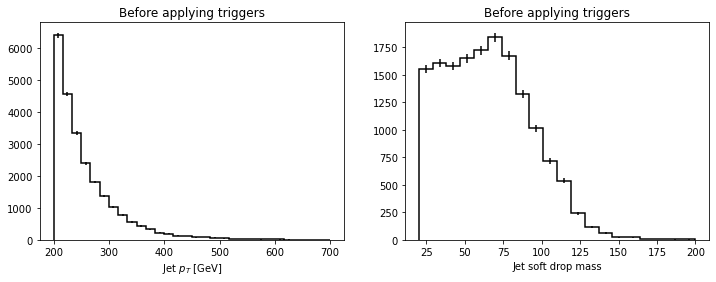

In [20]:
### before applying triggers (distribution plots)
jet_pt_deno = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{'channel':'e','region':'denominator','jetlepmass': sum,'jetmsoftdrop':sum}]
jetmsoftdrop_deno = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{'channel':'e','region':'denominator','jetlepmass':sum,'jetpt':sum}]

f, axs = plt.subplots(1,2, figsize=(12, 4))
hep.histplot(jet_pt_deno, yerr=True, ax=axs[0], color='k', label='semi-leptonic jets')
hep.histplot(jetmsoftdrop_deno, yerr=True, ax=axs[1], color='k', label='semi-leptonic jets')
axs[0].set_title('Before applying triggers')
axs[1].set_title('Before applying triggers');

# ### after applying triggers
# jet_pt_num = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8'][{'channel':'e','region':'numerator','jetlepmass': sum,'jetmsoftdrop':sum}]
# jetmsoftdrop_num = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{'channel':'e','region':'numerator','jetlepmass':sum,'jetpt':sum}]

# f, axs = plt.subplots(1,2, figsize=(12, 4))
# hep.histplot(jet_pt_num, yerr=True, ax=axs[0], color='k', label='semi-leptonic jets')
# hep.histplot(jetmsoftdrop_num, yerr=True, ax=axs[1], color='k', label='semi-leptonic jets')
# axs[0].set_title('After applying triggers')
# axs[1].set_title('After applying triggers');

### Trigger efficiency plots

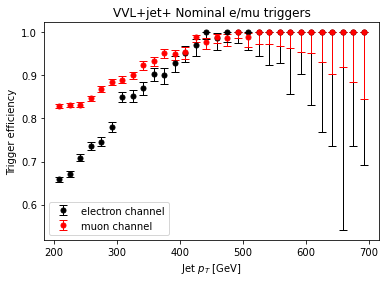

In [54]:
fig, ax = plt.subplots(1, 1)

num_e = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{"region": "numerator","channel": "e", 'jetlepmass':sum,'jetmsoftdrop':sum}]
den_e = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{"region": "denominator","channel": "e", 'jetlepmass':sum,'jetmsoftdrop':sum}]
num_mu = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{"region": "numerator","channel": "mu", 'jetlepmass':sum,'jetmsoftdrop':sum}]
den_mu = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{"region": "denominator","channel": "mu", 'jetlepmass':sum,'jetmsoftdrop':sum}]

hep.histplot(num_e/den_e, 
             # yerr is the relative shift from the y value
             yerr=abs(clopper_pearson_interval(num_e.view(), den_e.view()) - num_e.view()/den_e.view()),
             ax = ax,
             histtype='errorbar', color='k', capsize=4, elinewidth=1, label='electron channel'          
)

hep.histplot(num_mu/den_mu, 
             # yerr is the relative shift from the y value
             yerr=abs(clopper_pearson_interval(num_mu.view(), den_mu.view()) - num_mu.view()/den_mu.view()),
             ax = ax,
             histtype='errorbar', color='r', capsize=4, elinewidth=1, label='muon channel'          
)

#ax.set_ylim(0, 1)
# ax.set_title(f'Candidate jet $p_T$ GeV')
ax.set_ylabel(f'Trigger efficiency');
ax.set_title(f'VVL+jet+ Nominal e/mu triggers')
plt.legend()
plt.savefig('lol.pdf');

/tmp/ipykernel_119/1720594209.py:10: RuntimeWarning: invalid value encountered in true_divide
  yerr=abs(clopper_pearson_interval(num_e.view(), den_e.view()) - num_e.view()/den_e.view()),
/tmp/ipykernel_119/1720594209.py:17: RuntimeWarning: invalid value encountered in true_divide
  yerr=abs(clopper_pearson_interval(num_mu.view(), den_mu.view()) - num_mu.view()/den_mu.view()),


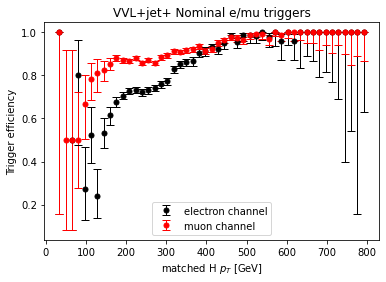

In [55]:
fig, ax = plt.subplots(1, 1)

num_e = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['higgs'][{"region": "numerator","channel": "e"}]
den_e = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['higgs'][{"region": "denominator","channel": "e"}]
num_mu = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['higgs'][{"region": "numerator","channel": "mu"}]
den_mu = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['higgs'][{"region": "denominator","channel": "mu"}]

hep.histplot(num_e/den_e, 
             # yerr is the relative shift from the y value
             yerr=abs(clopper_pearson_interval(num_e.view(), den_e.view()) - num_e.view()/den_e.view()),
             ax = ax,
             histtype='errorbar', color='k', capsize=4, elinewidth=1, label='electron channel'         
)

hep.histplot(num_mu/den_mu, 
             # yerr is the relative shift from the y value
             yerr=abs(clopper_pearson_interval(num_mu.view(), den_mu.view()) - num_mu.view()/den_mu.view()),
             ax = ax,
             histtype='errorbar', color='r', capsize=4, elinewidth=1, label='muon channel'          
)
#ax.set_ylim(0, 1)
# ax.set_title(f'Candidate jet $p_T$ GeV')
ax.set_ylabel(f'Trigger efficiency')
ax.set_title(f'VVL+jet+ Nominal e/mu triggers')
plt.legend()
plt.savefig('lol.pdf');

In [35]:
out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['lepton']

Hist(
  StrCategory(['e', 'mu'], growth=True, name='channel', label='channel'),
  StrCategory(['numerator', 'denominator'], name='region', label='region'),
  Regular(30, 10, 200, name='leppt', label='Lepton $p_T$ [GeV]'),
  storage=Double()) # Sum: 76040.0 (80830.0 with flow)

/tmp/ipykernel_119/2536957327.py:10: RuntimeWarning: invalid value encountered in true_divide
  yerr=abs(clopper_pearson_interval(num_e.view(), den_e.view()) - num_e.view()/den_e.view()),
/tmp/ipykernel_119/2536957327.py:17: RuntimeWarning: invalid value encountered in true_divide
  yerr=abs(clopper_pearson_interval(num_mu.view(), den_mu.view()) - num_mu.view()/den_mu.view()),


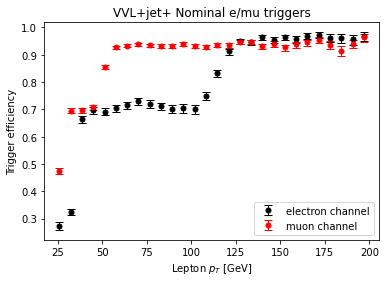

In [56]:
fig, ax = plt.subplots(1, 1)

num_e = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['lepton'][{"region": "numerator","channel": "e"}]
den_e = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['lepton'][{"region": "denominator","channel": "e"}]
num_mu = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['lepton'][{"region": "numerator","channel": "mu"}]
den_mu = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['lepton'][{"region": "denominator","channel": "mu"}]

hep.histplot(num_e/den_e, 
             # yerr is the relative shift from the y value
             yerr=abs(clopper_pearson_interval(num_e.view(), den_e.view()) - num_e.view()/den_e.view()),
             ax = ax,
             histtype='errorbar', color='k', capsize=4, elinewidth=1, label='electron channel'         
)

hep.histplot(num_mu/den_mu, 
             # yerr is the relative shift from the y value
             yerr=abs(clopper_pearson_interval(num_mu.view(), den_mu.view()) - num_mu.view()/den_mu.view()),
             ax = ax,
             histtype='errorbar', color='r', capsize=4, elinewidth=1, label='muon channel'          
)
#ax.set_ylim(0, 1)
# ax.set_title(f'Candidate jet $p_T$ GeV')
ax.set_ylabel(f'Trigger efficiency')
ax.set_title(f'VVL+jet+ Nominal e/mu triggers')
plt.legend()
plt.savefig('lol.pdf');

/tmp/ipykernel_119/1415320045.py:10: RuntimeWarning: invalid value encountered in true_divide
  yerr=abs(clopper_pearson_interval(num_e.view(), den_e.view()) - num_e.view()/den_e.view()),
/tmp/ipykernel_119/1415320045.py:17: RuntimeWarning: invalid value encountered in true_divide
  yerr=abs(clopper_pearson_interval(num_mu.view(), den_mu.view()) - num_mu.view()/den_mu.view()),


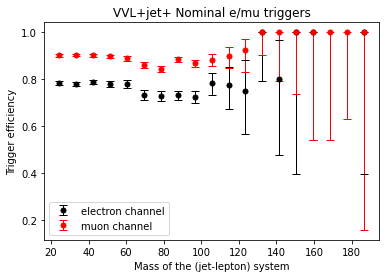

In [57]:
fig, ax = plt.subplots(1, 1)

num_e = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{"region": "numerator","channel": "e", 'jetmsoftdrop':sum, 'jetpt':sum}]
den_e = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{"region": "denominator","channel": "e", 'jetmsoftdrop':sum, 'jetpt':sum}]
num_mu = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{"region": "numerator","channel": "mu", 'jetmsoftdrop':sum, 'jetpt':sum}]
den_mu = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{"region": "denominator","channel": "mu", 'jetmsoftdrop':sum, 'jetpt':sum}]

hep.histplot(num_e/den_e, 
             # yerr is the relative shift from the y value
             yerr=abs(clopper_pearson_interval(num_e.view(), den_e.view()) - num_e.view()/den_e.view()),
             ax = ax,
             histtype='errorbar', color='k', capsize=4, elinewidth=1, label='electron channel'         
)

hep.histplot(num_mu/den_mu, 
             # yerr is the relative shift from the y value
             yerr=abs(clopper_pearson_interval(num_mu.view(), den_mu.view()) - num_mu.view()/den_mu.view()),
             ax = ax,
             histtype='errorbar', color='r', capsize=4, elinewidth=1, label='muon channel'          
)
#ax.set_ylim(0, 1)
# ax.set_title(f'Candidate jet $p_T$ GeV')
ax.set_ylabel(f'Trigger efficiency')
ax.set_title(f'VVL+jet+ Nominal e/mu triggers')
plt.legend()
plt.savefig('lol.pdf');

In [25]:
out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet']

Hist(
  StrCategory(['e', 'mu'], growth=True, name='channel', label='channel'),
  StrCategory(['numerator', 'denominator'], name='region', label='region'),
  Regular(20, 180, 2000, name='hactivity', label='Hadronic activity'),
  storage=Double()) # Sum: 7809.0 (7823.0 with flow)

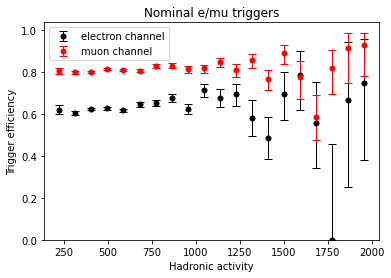

In [36]:
fig, ax = plt.subplots(1, 1)

num_e = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{"region": "numerator","channel": "e"}]
den_e = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{"region": "denominator","channel": "e"}]
num_mu = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{"region": "numerator","channel": "mu"}]
den_mu = out['GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8']['jet'][{"region": "denominator","channel": "mu"}]

hep.histplot(num_e/den_e, 
             # yerr is the relative shift from the y value
             yerr=abs(clopper_pearson_interval(num_e.view(), den_e.view()) - num_e.view()/den_e.view()),
             ax = ax,
             histtype='errorbar', color='k', capsize=4, elinewidth=1, label='electron channel'         
)

hep.histplot(num_mu/den_mu, 
             # yerr is the relative shift from the y value
             yerr=abs(clopper_pearson_interval(num_mu.view(), den_mu.view()) - num_mu.view()/den_mu.view()),
             ax = ax,
             histtype='errorbar', color='r', capsize=4, elinewidth=1, label='muon channel'          
)
#ax.set_ylim(0, 1)
# ax.set_title(f'Candidate jet $p_T$ GeV')
ax.set_ylabel(f'Trigger efficiency')
# ax.set_title(f'Nominal e/mu triggers')
ax.set_title(f'VVL triggers')
plt.legend()
plt.savefig('lol.pdf');